# <span style="font-width:bold; font-size: 3rem; color:#2656a3;">**Data Engineering and Machine Learning Operations in Business** </span> <span style="font-width:bold; font-size: 3rem; color:#333;">- Part 03: Training Pipeline</span>

## 🗒️ This notebook is divided into the following sections:
1. Feature selection.
2. Feature transformations.
3. Training datasets creation - splitting into train, validation and test sets.
4. Loading the training data.
5. Training the model.
6. Register the model to Hopsworks Model Registry.

## <span style='color:#2656a3'> ⚙️ Import of libraries and packages

In [1]:
!pip install tensorflow --quiet

In [2]:
# Importing the packages for the needed libraries for the Jupyter notebook
import inspect 
import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

2024-04-26 08:55:45.109340: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## <span style="color:#2656a3;"> 📡 Connecting to Hopsworks Feature Store

In [3]:
# Importing the hopsworks module
import hopsworks

# Logging in to the Hopsworks project
project = hopsworks.login()

# Getting the feature store from the project
fs = project.get_feature_store() 

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/550040
Connected. Call `.close()` to terminate connection gracefully.


In [4]:
# Retrieve the feature groups
electricity_fg = fs.get_feature_group(
    name='electricity_prices',
    version=1,
)

weather_fg = fs.get_feature_group(
    name='weather_measurements',
    version=1,
)

danish_holidays_fg = fs.get_feature_group(
    name='danish_holidays',
    version=1,
)
forecast_renewable_energy_fg = fs.get_feature_group(
    name='forecast_renewable_energy',
    version=1
)

## <span style="color:#2656a3;"> 🖍 Feature View Creation and Retrieving </span>

We first select the features that we want to include for model training.

Since we specified `primary_key`as `date` and `event_time` as `timestamp` in part 01 we can now join them together for the `electricity_fg`, `weather_fg` and `forecast_renewable_energy_fg`.

In [5]:
# Select features for training data
selected_features = electricity_fg.select_all()\
    .join(weather_fg.select_except(["timestamp", "time"]))\
    .join(forecast_renewable_energy_fg.select_except(["timestamp", "time"]))\
    .join(danish_holidays_fg.select_all())

In [6]:
# Uncomment this if you would like to view your selected features
# selected_features.show(5)

### <span style="color:#2656a3;"> 🤖 Transformation Functions</span>

We preprocess our data using *min-max scaling* on the numerical features and *label encoding* on the one categorical feature we have.
To achieve this, we create a mapping between our features and transformation functions. This ensures that transformation functions like min-max scaling are applied exclusively on the training data, preventing any data leakage into the validation or test sets.

To achieve this, we create a mapping between our features and transformation functions - ved ikke om man kan sige det her?

In [7]:
# Defining transformation functions for feature scaling and encoding
transformation_functions = {
        "dk1_spotpricedkk_kwh": fs.get_transformation_function(name="min_max_scaler"), 
        "dk1_offshore_wind_forecastintraday_kwh": fs.get_transformation_function(name="min_max_scaler"), 
        "dk1_onshore_wind_forecastintraday_kwh": fs.get_transformation_function(name="min_max_scaler"), 
        "dk1_solar_forecastintraday_kwh": fs.get_transformation_function(name="min_max_scaler"), 
        "temperature_2m": fs.get_transformation_function(name="min_max_scaler"), 
        "relative_humidity_2m": fs.get_transformation_function(name="min_max_scaler"), 
        "precipitation": fs.get_transformation_function(name="min_max_scaler"), 
        "rain": fs.get_transformation_function(name="min_max_scaler"), 
        "snowfall": fs.get_transformation_function(name="min_max_scaler"), 
        "weather_code": fs.get_transformation_function(name="min_max_scaler"), 
        "cloud_cover": fs.get_transformation_function(name="min_max_scaler"), 
        "wind_speed_10m": fs.get_transformation_function(name="min_max_scaler"),
        "wind_gusts_10m": fs.get_transformation_function(name="min_max_scaler"),
        "type": fs.get_transformation_function(name="label_encoder"),
    }

`Feature Views` stands between **Feature Groups** and **Training Dataset**. Сombining **Feature Groups** we can create **Feature Views** which store a metadata of our data. Having **Feature Views** we can create **Training Dataset**.

The Feature Views allows schema in form of a query with filters, define a model target feature/label and additional transformation functions.

In order to create Feature View we can use `FeatureStore.get_or_create_feature_view()` method.

We can specify next parameters:

- `name` - name of a feature group.

- `version` - version of a feature group.

- `labels`- our target variable.

- `transformation_functions` - functions to transform our features.

- `query` - query object with data.

ved ikke om den her omformulering af botten går an?

`Feature Views` serve as an intermediary between **Feature Groups** and the **Training Dataset**. By combining various **Feature Groups**, we can construct **Feature Views**, which retain metadata about our data. Utilizing **Feature Views**, we can subsequently generate a **Training Dataset**.

Feature Views facilitate the definition of schema through queries with filters, identification of the model's target feature or label, and application of additional transformation functions.

To create a Feature View, we employ the `FeatureStore.get_or_create_feature_view()` method, where we specify the following parameters:

- `name`: The name of the feature group.

- `version`: The version of the feature group.

- `labels`: Our target variable.

- `transformation_functions`: Functions to transform our features.

- `query`: A query object containing the relevant data.

In [8]:
# Getting or creating a feature view named 'electricity_feature_view'
version = 1 # Defining the version for the feature view
feature_view = fs.get_or_create_feature_view(
    name='electricity_feature_view',
    version=version,
    labels=[], # Labels will be defined manually later for our 'y'
    transformation_functions=transformation_functions,
    query=selected_features,
)

## <span style="color:#2656a3;"> 🏋️ Training Dataset Creation</span>

In Hopsworks training data is a query where the projection (set of features) is determined by the parent FeatureView with an optional snapshot on disk of the data returned by the query.

**Training Dataset  may contain splits such as:** 
* Training set - the subset of training data used to train a model.
* Validation set - the subset of training data used to evaluate hparams when training a model
* Test set - the holdout subset of training data used to evaluate a mode

Training dataset is created using `fs.create_training_dataset()` method.

**From feature view APIs you can also create training datasts based on even time filters specifing `start_time` and `end_time`** 

### <span style="color:#2656a3;"> ⛳️ Dataset with train, test and validation splits</span>

In [9]:
# Splitting the feature view data into train, validation, and test sets
# We didn't specify 'labels' in feature view creation, it will therefore return 'None' for Y
X_train, X_val, X_test, _, _, _ = feature_view.train_validation_test_split(
    train_start="2022-01-01",
    train_end="2023-06-30",
    validation_start="2023-07-01",
    validation_end="2023-09-30",
    test_start="2023-10-01",
    test_end="2023-12-31",
    description='Electricity price prediction dataset',
)

Finished: Reading data from Hopsworks, using ArrowFlight (244.68s) 


In [10]:
# Sorting the training, validation, and test datasets based on the 'timestamp' column
X_train.sort_values(["timestamp"], inplace=True)
X_val.sort_values(["timestamp"], inplace=True)
X_test.sort_values(["timestamp"], inplace=True)

In [11]:
# Extracting the target variable 'dk1_spotpricedkk_kwh' and defineing 'y_train', 'y_val' and 'y_test' 
y_train = X_train[["dk1_spotpricedkk_kwh"]]
y_val = X_val[["dk1_spotpricedkk_kwh"]]
y_test = X_test[["dk1_spotpricedkk_kwh"]]

In [12]:
# Dropping the 'date', 'time' and 'timestamp' columns from the training, validation, and test datasets
X_train.drop(["date", "time", "timestamp"], axis=1, inplace=True)
X_val.drop(["date", "time", "timestamp"], axis=1, inplace=True)
X_test.drop(["date", "time", "timestamp"], axis=1, inplace=True)

In [13]:
# # Dropping the 'dare', 'time' and 'timestamp' and dependent variable (y) columns from the training, validation, and test datasets
# X_train.drop(["dk1_spotpricedkk_kwh"], axis=1, inplace=True)
# X_val.drop(["dk1_spotpricedkk_kwh"], axis=1, inplace=True)
# X_test.drop(["dk1_spotpricedkk_kwh"], axis=1, inplace=True)

In [14]:
# Displaying the first 5 rows of the train dataset (X_train)
X_train.head()

,dk1_spotpricedkk_kwh,temperature_2m,relative_humidity_2m,precipitation,rain,snowfall,weather_code,cloud_cover,wind_speed_10m,wind_gusts_10m,dk1_offshore_wind_forecastintraday_kwh,dk1_onshore_wind_forecastintraday_kwh,dk1_solar_forecastintraday_kwh,type
6792723,0.179988,0.426339,1.000000,0.000000,0.000000,0.0,0.040000,1.0,0.256566,0.276795,0.945277,0.481878,0.000000,1
5636525,0.179988,0.419643,0.933333,0.000000,0.000000,0.0,0.040000,1.0,0.177778,0.138398,0.493641,0.133456,0.005406,1
5613878,0.179988,0.488839,0.933333,0.102273,0.102273,0.0,0.706667,1.0,0.450505,0.412071,0.913059,0.358547,0.000012,1
6794521,0.179988,0.446429,0.973333,0.000000,0.000000,0.0,0.040000,1.0,0.355556,0.318418,0.773045,0.264375,0.000018,1
5618773,0.179988,0.424107,0.960000,0.000000,0.000000,0.0,0.040000,1.0,0.230303,0.194589,0.282117,0.052855,0.019040,1


In [15]:

# Displaying the first 5 rows of the train dataset (y_train)
y_train.head()

,dk1_spotpricedkk_kwh
6792723,0.179988
5636525,0.179988
5613878,0.179988
6794521,0.179988
5618773,0.179988


## Prophet

## <span style="color:#2656a3;">🧬 Modeling XGBRegressor</span>

In [27]:
!pip install xgboost --quiet

In [28]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import os

In [29]:
# Initialize the XGBoost regressor
model = xgb.XGBRegressor()
model_val = xgb.XGBRegressor()

In [30]:
# Train the model on the training data
model.fit(X_train, y_train)

See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [31]:
# Make predictions on the validation set
y_test_pred = model.predict(X_test)

See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)


In [32]:
# Calculate RMSE on the validation set
mse = mean_squared_error(y_test, y_test_pred, squared=False)
print(f"Mean Squared Error (MSE): {mse}")

Mean Squared Error (MSE): 0.0014633574263666549


## <span style="color:#2656a3;">🗃 Window timeseries dataset </span>

In [33]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
                 df_train, val_df, test_df,
                 label_columns=None, batch_size=32):
        # Store the raw data.
        self.df_train = df_train
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(df_train.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

        self.batch_size = batch_size

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'
        ])

    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                axis=-1
            )

        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels

    def plot(self, plot_col, model=None, max_subplots=3):
        inputs, labels = self.example
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        for n in range(max_n):
            plt.subplot(max_n, 1, n + 1)
            plt.ylabel(f'{plot_col} [normed]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', label='Labels', c='#2ca02c', s=64)
            if model is not None:
                predictions = model(inputs)
                plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                            marker='X', edgecolors='k', label='Predictions',
                            c='#ff7f0e', s=64)

            if n == 0:
                plt.legend()

        plt.xlabel('Time [h]')

    # make_dataset method will take a time series DataFrame and convert it to a tf.data.Dataset of (input_window, label_window)
    # pairs using the tf.keras.utils.timeseries_dataset_from_array function:
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.utils.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=False,
            batch_size=self.batch_size,
        )
        ds = ds.map(self.split_window)
        ds = ds.repeat(1000)
        ds = ds.prefetch(10)
        return ds

    @property
    def train(self):
        return self.make_dataset(self.df_train)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def example(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, '_example', None)
        if result is None:
            # No example batch was found, so get one from the `.train` dataset
            result = next(iter(self.test))
            # And cache it for next time
            self._example = result
        return result

In [34]:
# Creating a WindowGenerator instance
# The window represents a time series data window with an input width of 4, label width of 4, and a shift of 1
# The label columns are ["price_se1", "price_se2", "price_se3", "price_se4"]
n_step_window = WindowGenerator(
    df_train=X_train, 
    val_df=X_val, 
    test_df=X_test, 
    input_width=1, 
    label_width=1, 
    shift=1, 
    label_columns=["dk1_spotpricedkk_kwh"],
)

# Displaying the WindowGenerator instance
n_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['dk1_spotpricedkk_kwh']

In [35]:
# Extracting an example batch of inputs and labels from the WindowGenerator instance
inputs, labels = n_step_window.example

# Displaying the shapes of the input and label tensors
print(inputs.shape)
print(labels.shape)

# Displaying the indices of label columns in the dataset
print(n_step_window.label_indices)

See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)


(32, 1, 14)
(32, 1, 1)
[1]


In [36]:
# Iterating over the training dataset (n_step_window.train) to extract an example batch of inputs and labels
for example_inputs, example_labels in n_step_window.train.take(1):
    # Displaying the shape of the example batch of inputs
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    
    # Displaying the shape of the example batch of labels
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 14)
Labels shape (batch, time, features): (32, 1, 1)


2024-04-26 09:41:29.041465: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## <span style="color:#2656a3;">🧬 Modeling Testing</span>

In [37]:
def build_model(input_dim):
    # Creating a Sequential model
    model = tf.keras.models.Sequential()

    # Adding a 1D convolutional layer
    model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=1, padding='same', kernel_initializer="uniform", input_shape=(input_dim[0], input_dim[1])))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))

    # Adding 1D convolutional layer
    model.add(tf.keras.layers.Conv1D(filters=32, kernel_size=1, padding='same', kernel_initializer="uniform"))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))

    # Adding 1D convolutional layer
    model.add(tf.keras.layers.Conv1D(filters=16, kernel_size=1, padding='same', kernel_initializer="uniform"))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    
    # Adding a 1D max pooling layer
    model.add(tf.keras.layers.MaxPooling1D(pool_size=1, padding='same'))

    # Adding a Bidirectional LSTM layer
    model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=16, return_sequences=True))) 
    model.add(tf.keras.layers.Dropout(rate=0.1))

    # Adding a Dense layer
    model.add(tf.keras.layers.Dense(units=4))

    # Displaying the model summary
    model.summary()

    # Compiling the model with mean absolute error loss and the Adam optimizer
    model.compile(loss='mae', optimizer='adam')

    return model

In [38]:
# Building a model using the specified input shape derived from the example batch of inputs
model = build_model(inputs.shape[1:])

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 1, 64)          │           960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1, 64)          │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 1, 32)          │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1, 32)          │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 1, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 1, 16)          │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 1, 16)          │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 1, 16)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 1, 16)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 1, 32)          │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1, 4)           │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,372 (32.70 KB)

 Trainable params: 8,148 (31.83 KB)

 Non-trainable params: 224 (896.00 B)

In [39]:
# Recording the start time
from timeit import default_timer as timer
start = timer()

# Training the model on the training dataset with specified parameters
# - Using 50 epochs
# - Displaying minimal training information (verbose=0)
# - Specifying the number of steps per epoch (steps_per_epoch=200)
# - Using the training dataset for validation (validation_data=n_step_window.train)
# - Specifying the number of validation steps (validation_steps=1)
history = model.fit(
    n_step_window.train,
    epochs=50,
    verbose=0,
    steps_per_epoch=200,
    validation_data=n_step_window.train,
    validation_steps=1,                    
)

# Recording the end time
end = timer()

# Displaying the time taken for training
print(end - start)

In [23]:
# Extracting an example batch of inputs and labels from the WindowGenerator instance (n_step_window)
inputs, labels = n_step_window.example

# Making predictions on the example batch using the trained model
prediction_test = model.predict(inputs)

# Displaying the shapes of the predicted outputs and the true labels
print(prediction_test.shape)
print(labels.shape)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step
(32, 1, 4)
(32, 1, 1)


In [24]:
# Extracting the training history dictionary from the model training
history_dict = history.history

# Displaying the keys in the history dictionary
print(history_dict.keys())

dict_keys(['loss', 'val_loss'])


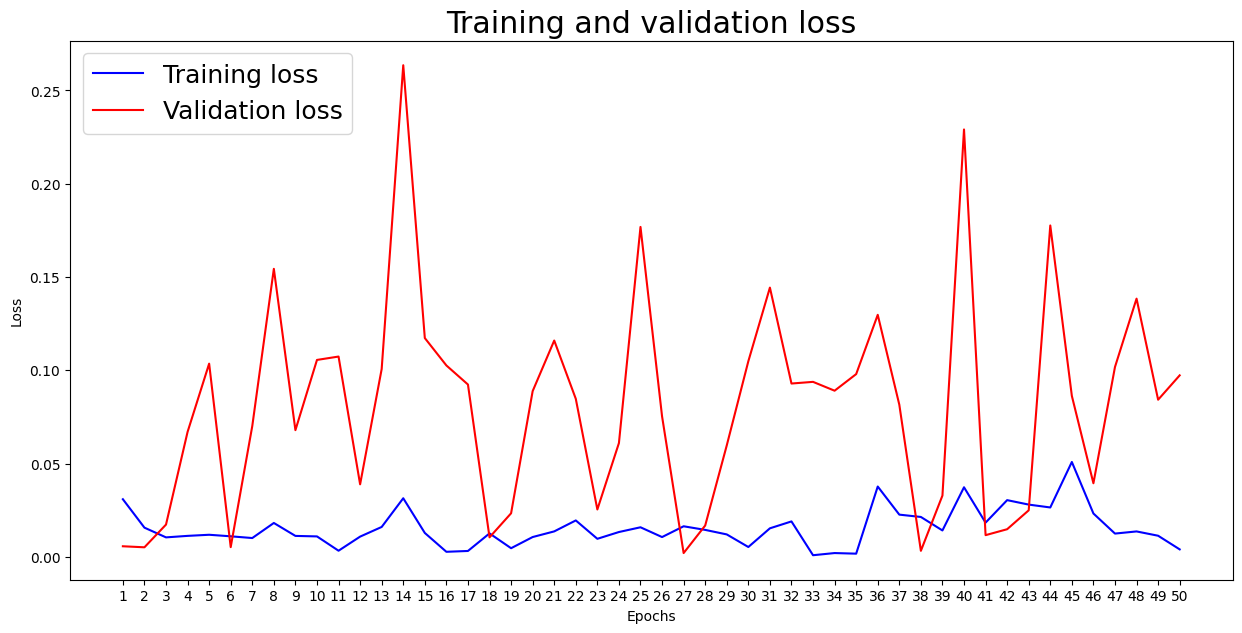

In [25]:
# Extracting training and validation loss values from the history dictionary
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

# Creating separate variables for loss values (50 epochs)
loss_values50 = loss_values
val_loss_values50 = val_loss_values

# Generating a plot for training and validation loss over epochs
epochs = range(1, len(loss_values50) + 1)
plt.plot(epochs, loss_values50, 'b', color='blue', label='Training loss')
plt.plot(epochs, val_loss_values50, 'b', color='red', label='Validation loss')

# Setting plot details and labels
plt.rc('font', size=18)
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.xticks(epochs)

# Adjusting the size of the plot
fig = plt.gcf()
fig.set_size_inches(15, 7)

# Displaying the plot
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


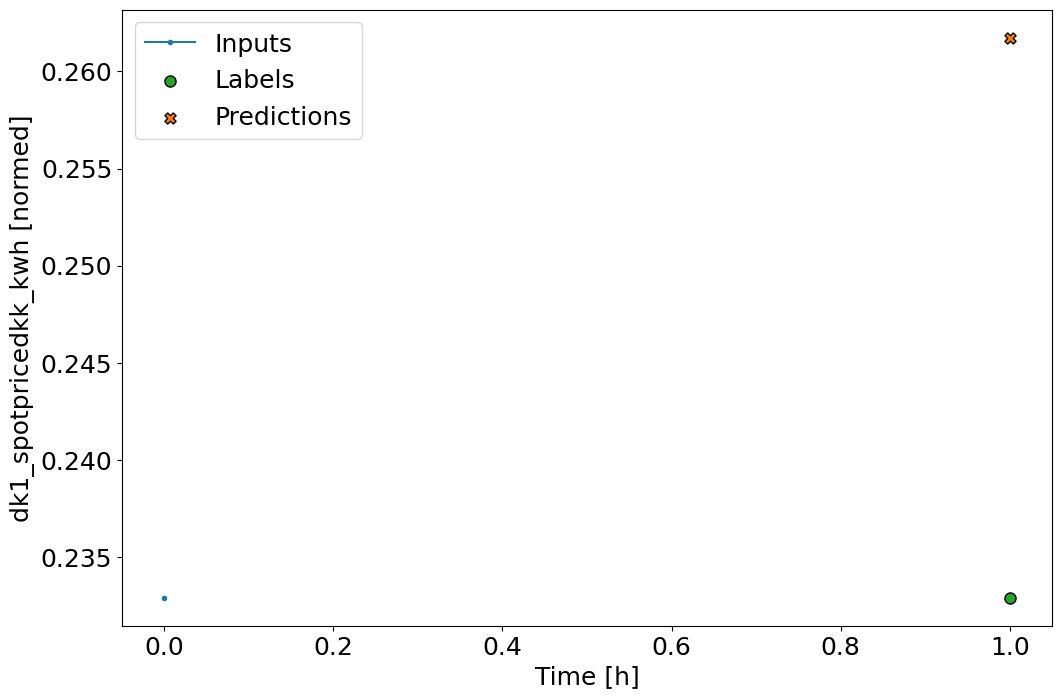

In [30]:
# Plotting the time series data for the 'dk1_spotpricedkk_kwh' column
n_step_window.plot(
    plot_col="dk1_spotpricedkk_kwh", 
    max_subplots=1, 
    model=model.predict,
)

In [32]:
# Extracting actual values for each time step in the example batch
dk1_spotpricedkk_kwh_actual = []

# Extracting inputs and labels from the example batch of the WindowGenerator instance (n_step_window)
inputs, labels = n_step_window.example

# Iterating over batches and windows to collect actual values for each time step
for batch_n in range(len(labels)):
    batch = labels[batch_n]
    for window_n in range(1):
        dk1_spotpricedkk_kwh_actual.append(batch[window_n][0].numpy())


In [33]:
# Extracting predicted values for each time step in the example batch using the trained model
dk1_spotpricedkk_kwh_pred = []

# Making predictions on the example batch using the trained model
prediction_test = model.predict(inputs)

# Iterating over batches and windows to collect predicted values for each time step
for batch_n in range(len(prediction_test)):
    batch = prediction_test[batch_n]
    for window_n in range(1):
        dk1_spotpricedkk_kwh_pred.append(batch[window_n][0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


In [34]:
# Displaying the first 10 rows of the true labels (y_test)
y_test.head(10)

,dk1_spotpricedkk_kwh
7576262,0.232907
529459,0.232907
2869662,0.232907
7535144,0.232907
1710505,0.232907
1710471,0.232907
516953,0.232907
2870213,0.232907
2870384,0.232907
1710439,0.232907


In [35]:
# Displaying the value at index 1 in the list 'dk1_spotpricedkk_kwh_actual'
dk1_spotpricedkk_kwh_actual[1]

0.2329069

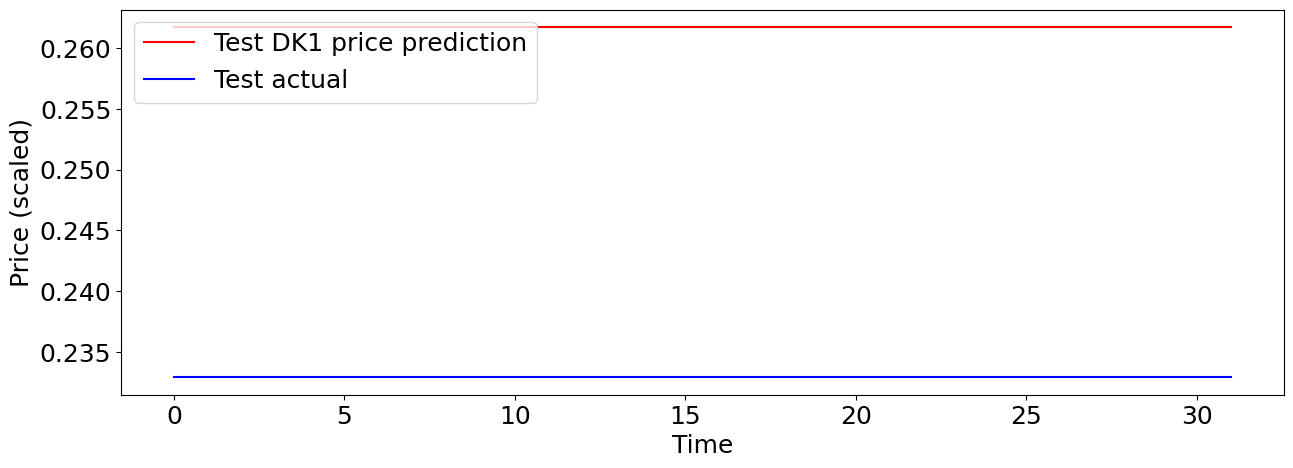

In [38]:
# Plotting the predicted and actual values for "DK1" prices over time
plt.plot(dk1_spotpricedkk_kwh_pred, color='red', label='Test DK1 price prediction')
plt.plot(dk1_spotpricedkk_kwh_actual, color='blue', label='Test actual')
plt.xlabel('Time')
plt.ylabel('Price (scaled)')
plt.legend(loc='upper left')

# Adjusting the size of the plot
fig = plt.gcf()
fig.set_size_inches(15, 5)

# Displaying the plot
plt.show()

## <span style="color:#2656a3;">🧬 Modeling</span>

In [ ]:
# import pandas as pd
# import numpy as np
# import xgboost as xgb
# from sklearn.metrics import mean_squared_error
# import os

In [ ]:
# # Initialize the XGBoost regressor
# model = xgb.XGBRegressor()
# model_val = xgb.XGBRegressor()

In [ ]:
# # Train the model on the training data
# model.fit(X_train, y_train)

In [ ]:
# # Make predictions on the validation set
# y_test_pred = model.predict(X_test)

In [ ]:
# # Calculate RMSE on the validation set
# mse = mean_squared_error(y_test, y_test_pred, squared=False)
# print(f"Mean Squared Error (MSE): {mse}")

## <span style='color:#2656a3'>🗄 Model Registry</span>

In [39]:
# Exporting the trained model to a directory
model_dir = "electricity_price_model"
print('Exporting trained model to: {}'.format(model_dir))

# Saving the model using TensorFlow's saved_model.save function
tf.saved_model.save(model, model_dir)

Exporting trained model to: electricity_price_model
INFO:tensorflow:Assets written to: electricity_price_model\assets


In [44]:
# Retrieving the Model Registry
mr = project.get_model_registry()

# Extracting loss value from the training history
metrics = {'loss': history_dict['val_loss'][0]} 

# Creating a TensorFlow model in the Model Registry
tf_model = mr.tensorflow.create_model(
    name="DK_electricity_price_prediction_model",
    metrics=metrics,
    description="Hourly electricity price prediction model.",
    input_example=n_step_window.example[0].numpy(),
)

# Saving the model to the specified directory
tf_model.save(model_dir)

Connected. Call `.close()` to terminate connection gracefully.


Uploading: 100.000%|██████████| 59/59 elapsed<00:01 remaining<00:001<00:01,  3.38it/s]
Uploading: 100.000%|██████████| 397272/397272 elapsed<00:02 remaining<00:00  3.38it/s]
Uploading: 0.000%|          | 0/112411 elapsed<00:01 remaining<?0:04<00:01,  3.38it/s]
Uploading model files (2 dirs, 2 files):  17%|█▋        | 1/6 [00:07<00:35,  7.08s/it]


RestAPIError: Metadata operation error: (url: https://c.app.hopsworks.ai/hopsworks-api/api/project/556180/dataset/upload/%2FProjects%2Fbenjami3%2FModels%2FDK_electricity_price_prediction_model%2F1%5Cvariables). Server response: 
HTTP code: 400, HTTP reason: Invalid URI, body: b''

---

## <span style="color:#2656a3;">⏭️ **Next:** Part 04: Batch Inference </span>

In the next notebook you will use your registered model to predict batch data.